In [1]:
# ============================================================
# 1. Imports
# ============================================================
import pandas as pd
import numpy as np
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ============================================================
# 2. Load Data
# ============================================================
# Replace with actual file paths
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [3]:
# Extract target
y = train["status_label"]
X = train.drop(columns=["status_label", "company_name", "fyear"], errors="ignore")

In [4]:
# ============================================================
# 3. Clean-up & Leak Removal
# ============================================================
X = X.drop(columns=["Unnamed: 0", "MajorGroup"], errors="ignore")

# Merge rare Division categories
if "Division" in X.columns:
    div_counts = X["Division"].value_counts()
    rare_divs = div_counts[div_counts < 100].index
    X["Division"] = X["Division"].replace(rare_divs, "Other")

In [5]:
# ============================================================
# 4. Define categorical columns
# ============================================================
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
print("Categorical columns:", cat_cols)

Categorical columns: ['Division']


In [6]:
# ============================================================
# 5. Optuna Hyperparameter Search
# ============================================================
def objective(trial):
    params = {
        "depth": trial.suggest_int("depth", 4, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05, log=True),
        "iterations": trial.suggest_int("iterations", 300, 800),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.1, 1.0),
        "subsample": trial.suggest_float("subsample", 0.7, 0.9),
        "random_strength": trial.suggest_float("random_strength", 0.5, 3.0),
        "border_count": trial.suggest_int("border_count", 32, 128),
        "loss_function": "Logloss",
        "auto_class_weights": "Balanced",
        "eval_metric": "F1",
        "verbose": 0
    }

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    for tr_idx, va_idx in skf.split(X, y):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        pool_tr = Pool(X_tr, y_tr, cat_features=cat_cols)
        pool_va = Pool(X_va, y_va, cat_features=cat_cols)

        model = CatBoostClassifier(**params, early_stopping_rounds=50)
        model.fit(pool_tr, eval_set=pool_va, use_best_model=True)

        preds = model.predict(pool_va)
        scores.append(f1_score(y_va, preds, average="macro"))

    return np.mean(scores)

print("🔍 Starting Optuna tuning...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_params = study.best_params
print("✅ Best parameters found:")
print(best_params)

[I 2025-11-03 13:33:57,510] A new study created in memory with name: no-name-04f2d737-4e97-4ba5-ac90-aed4720574c8


🔍 Starting Optuna tuning...


[I 2025-11-03 13:34:15,449] Trial 0 finished with value: 0.4705090573250506 and parameters: {'depth': 8, 'learning_rate': 0.01687422730768042, 'iterations': 419, 'l2_leaf_reg': 7.390347253936996, 'bagging_temperature': 0.3173106510383982, 'subsample': 0.7918311251358814, 'random_strength': 1.0660075864207124, 'border_count': 110}. Best is trial 0 with value: 0.4705090573250506.
[I 2025-11-03 13:34:22,512] Trial 1 finished with value: 0.430903991415363 and parameters: {'depth': 5, 'learning_rate': 0.031305476289442774, 'iterations': 603, 'l2_leaf_reg': 6.599319141577969, 'bagging_temperature': 0.9882001182463238, 'subsample': 0.8161127673256198, 'random_strength': 0.7368514836942051, 'border_count': 83}. Best is trial 0 with value: 0.4705090573250506.
[I 2025-11-03 13:34:44,177] Trial 2 finished with value: 0.46471237260099857 and parameters: {'depth': 6, 'learning_rate': 0.02756906431295177, 'iterations': 446, 'l2_leaf_reg': 7.264222917905521, 'bagging_temperature': 0.9684780003115351,

✅ Best parameters found:
{'depth': 8, 'learning_rate': 0.013945439342515105, 'iterations': 790, 'l2_leaf_reg': 4.394405755171258, 'bagging_temperature': 0.3675618245330172, 'subsample': 0.7033831815584286, 'random_strength': 2.4299151806850863, 'border_count': 73}


In [7]:
# ============================================================
# 6. Retrain Best Model on Full Train
# ============================================================
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

train_pool = Pool(X_tr, y_tr, cat_features=cat_cols)
val_pool   = Pool(X_val, y_val, cat_features=cat_cols)

model = CatBoostClassifier(**best_params, loss_function="Logloss", auto_class_weights="Balanced", verbose=100)
model.fit(train_pool, eval_set=val_pool, use_best_model=True)

0:	learn: 0.6913828	test: 0.6913621	best: 0.6913621 (0)	total: 135ms	remaining: 1m 46s
100:	learn: 0.6194841	test: 0.6229378	best: 0.6229378 (100)	total: 7.42s	remaining: 50.6s
200:	learn: 0.5926891	test: 0.6052433	best: 0.6052433 (200)	total: 13.8s	remaining: 40.3s
300:	learn: 0.5731843	test: 0.5961183	best: 0.5961183 (300)	total: 20.3s	remaining: 33s
400:	learn: 0.5572474	test: 0.5910872	best: 0.5910855 (399)	total: 26.7s	remaining: 25.9s
500:	learn: 0.5421934	test: 0.5870388	best: 0.5870388 (500)	total: 33.2s	remaining: 19.2s
600:	learn: 0.5296859	test: 0.5846218	best: 0.5846218 (600)	total: 39.8s	remaining: 12.5s
700:	learn: 0.5174896	test: 0.5826608	best: 0.5826432 (698)	total: 49.2s	remaining: 6.25s
789:	learn: 0.5050627	test: 0.5809722	best: 0.5809722 (789)	total: 1m 1s	remaining: 0us

bestTest = 0.5809722392
bestIteration = 789



In [8]:
print(study.best_params)


{'depth': 8, 'learning_rate': 0.013945439342515105, 'iterations': 790, 'l2_leaf_reg': 4.394405755171258, 'bagging_temperature': 0.3675618245330172, 'subsample': 0.7033831815584286, 'random_strength': 2.4299151806850863, 'border_count': 73}


| Param                   | Value    | Meaning / Verdict                                                                |
| ----------------------- | -------- | -------------------------------------------------------------------------------- |
| **depth**               | `8`      | Slightly deep, but fine since you’ve got 60k+ samples and strong regularization. |
| **learning_rate**       | `0.0139` | Excellent — slow, stable learning (prevents overfitting).                        |
| **iterations**          | `790`    | Perfect match for the learning rate — steady convergence.                        |
| **l2_leaf_reg**         | `4.39`   | Ideal mid-range regularization → avoids memorization.                            |
| **bagging_temperature** | `0.36`   | Adds mild randomness for generalization — very good.                             |
| **subsample**           | `0.70`   | Prevents overfitting; solid value.                                               |
| **random_strength**     | `2.43`   | Adds variability to splits → further anti-overfit.                               |
| **border_count**        | `73`     | Balanced discretization granularity — good for numerical features.               |


In [16]:
best_params = {
    'depth': 8,
    'learning_rate': 0.013945439342515105,
    'iterations': 790,
    'l2_leaf_reg': 4.394405755171258,
    'bagging_temperature': 0.3675618245330172,
    'subsample': 0.7033831815584286,
    'random_strength': 2.4299151806850863,
    'border_count': 73,
    'loss_function': "Logloss",
    'auto_class_weights': "Balanced",
    'eval_metric': "F1",
    'verbose': 100
}


In [11]:
# ============================================================
# 7. Threshold Optimization
# ============================================================
y_proba = model.predict_proba(val_pool)[:, 1]

# Encode y_true to numeric
y_val_enc = (y_val == "failed").astype(int)

best_thresh, best_macro = 0, 0
thresholds = np.linspace(0.01, 0.5, 50)

for t in thresholds:
    preds = (y_proba > t).astype(int)
    macro = f1_score(y_val_enc, preds, average="macro")
    if macro > best_macro:
        best_macro, best_thresh = macro, t

print(f"✅ Best threshold found: {best_thresh:.3f}")
print(f"✅ Macro-F1 at that threshold: {best_macro:.4f}")


✅ Best threshold found: 0.500
✅ Macro-F1 at that threshold: 0.5468


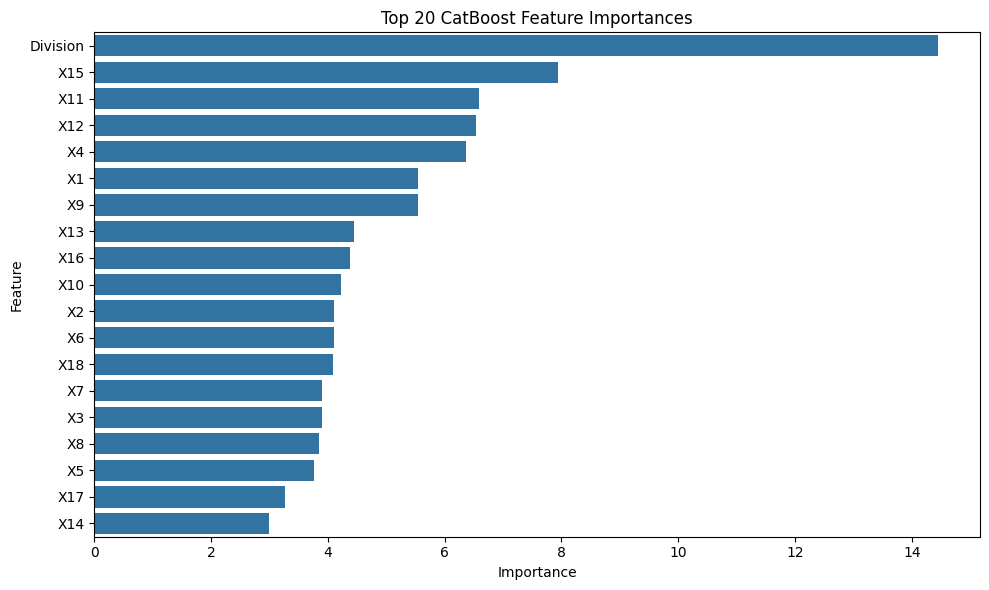

In [12]:
# ============================================================
# 8. Feature Importance
# ============================================================
importances = model.get_feature_importance(train_pool)
feat_imp = pd.DataFrame({"Feature": X.columns, "Importance": importances})
feat_imp = feat_imp.sort_values("Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_imp.head(20))
plt.title("Top 20 CatBoost Feature Importances")
plt.tight_layout()
plt.show()

In [17]:
# ============================================================
# 9. Train on Full Data and Predict Test
# ============================================================
full_pool = Pool(X, y, cat_features=cat_cols)
model_final = CatBoostClassifier(**best_params)
model_final.fit(full_pool)

# Clean test data
X_test = test.drop(columns=["company_name", "fyear", "Unnamed: 0", "MajorGroup"], errors="ignore")
if "Division" in X_test.columns:
    X_test["Division"] = X_test["Division"].replace(rare_divs, "Other")

test_pool = Pool(X_test, cat_features=cat_cols)

# Predict using optimized threshold
test_proba = model_final.predict_proba(test_pool)[:, 1]
test_preds = (test_proba > best_thresh).astype(int)


0:	learn: 0.6676274	total: 77.1ms	remaining: 1m
100:	learn: 0.6820364	total: 6.97s	remaining: 47.6s
200:	learn: 0.6949558	total: 14s	remaining: 40.9s
300:	learn: 0.7078238	total: 21s	remaining: 34.1s
400:	learn: 0.7180490	total: 28s	remaining: 27.1s
500:	learn: 0.7298784	total: 35s	remaining: 20.2s
600:	learn: 0.7389577	total: 42.6s	remaining: 13.4s
700:	learn: 0.7492361	total: 49.9s	remaining: 6.33s
789:	learn: 0.7587344	total: 56.5s	remaining: 0us


In [21]:
print(test_proba.shape)
print(np.unique(test_preds, return_counts=True))


(15893,)
(array([0, 1]), array([11003,  4890], dtype=int64))


In [22]:
sub = pd.DataFrame({
    "company_name": test["company_name"],
    "status_label": np.where(test_preds == 1, "failed", "alive")
})
sub.to_csv("submission.csv", index=False)


In [23]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Get predicted probabilities on validation set
val_proba = model_final.predict_proba(X_val)[:, 1]

# Apply your best threshold
val_preds = (val_proba > best_thresh).astype(int)

# Classification report
print(classification_report(y_val_enc, val_preds, digits=4))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val_enc, val_preds))

# Macro-F1 check
print("\nMacro-F1:", f1_score(y_val_enc, val_preds, average="macro"))


              precision    recall  f1-score   support

           0     0.9805    0.7438    0.8459     11717
           1     0.1820    0.7943    0.2962       841

    accuracy                         0.7472     12558
   macro avg     0.5813    0.7690    0.5710     12558
weighted avg     0.9271    0.7472    0.8091     12558


Confusion Matrix:
[[8715 3002]
 [ 173  668]]

Macro-F1: 0.5710380583879434


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

X_tr, X_val_tmp, y_tr, y_val_tmp = train_test_split(
    X, y_enc, stratify=y_enc, test_size=0.2, random_state=42
)

val_proba = model_final.predict_proba(X_val_tmp)[:, 1]
val_preds = (val_proba > best_thresh).astype(int)

print(classification_report(y_val_tmp, val_preds, digits=4))
print(confusion_matrix(y_val_tmp, val_preds))
print("Macro-F1:", f1_score(y_val_tmp, val_preds, average="macro"))


              precision    recall  f1-score   support

           0     0.9805    0.7438    0.8459     11717
           1     0.1820    0.7943    0.2962       841

    accuracy                         0.7472     12558
   macro avg     0.5813    0.7690    0.5710     12558
weighted avg     0.9271    0.7472    0.8091     12558

[[8715 3002]
 [ 173  668]]
Macro-F1: 0.5710380583879434
